<a href="https://colab.research.google.com/github/Meyyappan-T/-Implementation-of-Logistic-Regression-Using-Gradient-Descent/blob/main/Workshop_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [8]:
df = pd.read_csv('adult.csv')

# Identify columns
cat_cols = ['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Gender', 'Native Country']
con_cols = ['Age', 'Final Weight', 'EducationNum', 'Capital Gain', 'capital loss', 'Hours per Week']
target_col = 'Income'

# Handle missing values in categorical columns (replace '?' with 'Unknown')
for col in cat_cols:
    df[col] = df[col].replace(' ?', 'Unknown')

# Encode target: <=50K -> 0, >50K -> 1
df[target_col] = (df[target_col] == ' >50K').astype(int)

# Split into train and test (25,000 train, 5,000 test)
# Assuming the dataset has at least 30,000 rows as per task
train_df, test_df = train_test_split(df, train_size=25000, random_state=33, stratify=df[target_col])

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (25000, 15), Test shape: (7561, 15)


In [9]:
def encode_categorical(df, cat_columns):
    encoded = {}
    for col in cat_columns:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        encoded[col] = df[col].map(mapping).values
    return encoded

cat_train_encoded = encode_categorical(train_df, cat_cols)
cat_test_encoded = encode_categorical(test_df, cat_cols)

# Stack into arrays (N, num_cat_features)
cat_train = np.stack([cat_train_encoded[col] for col in cat_cols], axis=1).astype(np.int64)
cat_test = np.stack([cat_test_encoded[col] for col in cat_cols], axis=1).astype(np.int64)

# Continuous features
con_train = train_df[con_cols].values.astype(np.float32)
con_test = test_df[con_cols].values.astype(np.float32)

# Labels as LongTensor for CrossEntropyLoss
y_train = torch.LongTensor(train_df[target_col].values)
y_test = torch.LongTensor(test_df[target_col].values)

# Convert to tensors
cat_train_tensor = torch.from_numpy(cat_train)
cat_test_tensor = torch.from_numpy(cat_test)
con_train_tensor = torch.from_numpy(con_train)
con_test_tensor = torch.from_numpy(con_test)

print(f"Cat train shape: {cat_train_tensor.shape}")
print(f"Con train shape: {con_train_tensor.shape}")
print(f"y train shape: {y_train.shape}")

Cat train shape: torch.Size([25000, 8])
Con train shape: torch.Size([25000, 6])
y train shape: torch.Size([25000])


In [10]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_sz, sz, p=0.4):
        super().__init__()
        # Embeddings for categorical
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)

        # BatchNorm for continuous
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Layers: one hidden layer of 50 neurons with dropout
        emb_total_sz = sum([nf for ni, nf in emb_sizes])
        inp_sz = emb_total_sz + n_cont
        self.layers = nn.Sequential(
            nn.Linear(inp_sz, sz),
            nn.ReLU(),
            nn.BatchNorm1d(sz),
            nn.Dropout(p),
            nn.Linear(sz, out_sz)
        )

    def forward(self, x_cat, x_cont):
        # Embed categorical
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeds)]
        x_emb = torch.cat(embeddings, dim=1)
        x_emb = self.emb_drop(x_emb)

        # Normalize continuous
        x_cont = self.bn_cont(x_cont)

        # Concatenate
        x = torch.cat([x_emb, x_cont], dim=1)

        # Pass through layers
        x = self.layers(x)
        return x

In [11]:
# Embedding sizes: (n_categories, min(50, (n_cat+1)//2))
emb_sizes = [(len(train_df[col].unique()), min(50, (len(train_df[col].unique()) + 1) // 2)) for col in cat_cols]
n_cont = len(con_cols)
out_sz = 2  # Binary classification
sz = 50  # Hidden layer size

model = TabularModel(emb_sizes, n_cont, out_sz, sz, p=0.4)

print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(16, 8)
    (2): Embedding(7, 4)
    (3): Embedding(15, 8)
    (4): Embedding(6, 3)
    (5): Embedding(5, 3)
    (6): Embedding(2, 1)
    (7): Embedding(42, 21)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=59, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [12]:
torch.manual_seed(33)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 0/300, Loss: 0.9063
Epoch 50/300, Loss: 0.5177
Epoch 100/300, Loss: 0.4234
Epoch 150/300, Loss: 0.3737
Epoch 200/300, Loss: 0.3557
Epoch 250/300, Loss: 0.3420


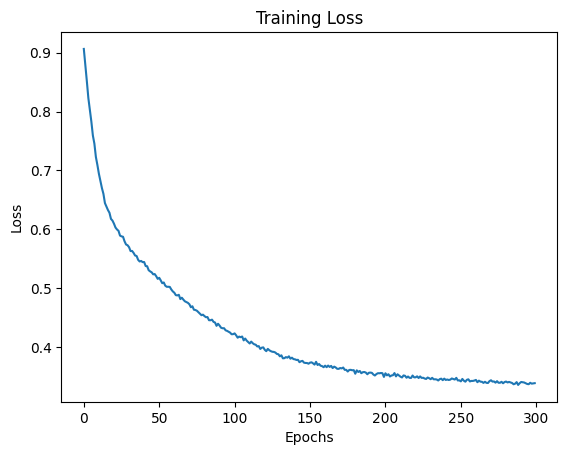

In [13]:
epochs = 300
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    yhat = model(cat_train_tensor, con_train_tensor)
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())

    if epoch % 50 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}')

# Plot losses
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [15]:
model.eval()
with torch.no_grad():
    yhat_test = model(cat_test_tensor, con_test_tensor)
    test_loss = criterion(yhat_test, y_test).item()

    # Predictions
    probs = torch.softmax(yhat_test, dim=1)
    preds = torch.argmax(probs, dim=1)

    # Accuracy
    accuracy = (preds == y_test).float().mean().item() * 100
print("Name:Meyyappan T")
print("Reg no:212223240086")
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Name:Meyyappan T
Reg no:212223240086
Test Loss: 0.4821
Test Accuracy: 79.87%


In [16]:
def predict_income(model, cat_input_dict, con_input_list):
    """
    Predict income for new data.
    cat_input_dict: dict of categorical values (must match cat_cols order)
    con_input_list: list of continuous values (must match con_cols order)
    """
    # Encode cats (using train mappings, assume same)
    cat_encoded = []
    for i, col in enumerate(cat_cols):
        unique_train = train_df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_train)}
        if cat_input_dict[col] not in mapping:
            # Handle unknown: map to last index or 'Unknown'
            if 'Unknown' in mapping:
                cat_encoded.append(mapping['Unknown'])
            else:
                cat_encoded.append(len(unique_train) - 1)  # Fallback
        else:
            cat_encoded.append(mapping[cat_input_dict[col]])

    cat_new = torch.LongTensor([cat_encoded])
    con_new = torch.FloatTensor([con_input_list])

    model.eval()
    with torch.no_grad():
        yhat = model(cat_new, con_new)
        prob = torch.softmax(yhat, dim=1)
        pred_class = torch.argmax(prob, dim=1).item()
        pred_prob = prob[0][1].item()  # Probability of >50K

    return ' >50K' if pred_class == 1 else ' <=50K', pred_prob

# Example usage (replace with actual values)
example_cat = {'Workclass': 'Private', 'Education': 'Bachelors', 'Marital Status': 'Married-civ-spouse',
               'Occupation': 'Exec-managerial', 'Relationship': 'Husband', 'Race': 'White',
               'Gender': 'Male', 'Native Country': 'United-States'}
example_con = [40, 100000, 13, 0, 0, 40]  # Age, fnlwgt, EducationNum, Cap Gain, Cap Loss, Hours/Week

prediction, prob = predict_income(model, example_cat, example_con)
print(f'Prediction: {prediction} (Probability >50K: {prob:.4f})')


Prediction:  <=50K (Probability >50K: 0.2272)
